## `Initial Setup`

In [1]:
import pandas as pd
import subprocess
import json
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context = 'notebook')

In [2]:
def skim_data(data):
    summary = pd.DataFrame({
                    'column': data.columns.values,
                    'type': data.dtypes.values,
                    'n_unique': data.nunique().values,
                    'min': data.min().values,
                    'max': data.max().values,
                    'sample_unique': [data[col].unique() for col in data.columns]
                })
    return summary

# `Data Understanding`

Notebook ini berisi penjelasan mengenai pemahaman dataset khususnya dari segi kelengkapan data untuk melakukan prediksi demand Capital Bikeshare.

## `1. Data Collection`

### **1.1 Provided Data**

Akses dataset <a href='https://drive.google.com/file/d/1lSbp2GTSgE8jwvA2K8rlLRZIUTWNNfXe/view?usp=drive_link'>disini</a>.

In [3]:
df = pd.read_csv('../data/raw/data_bike_sharing.csv')
print(f'Jumlah baris dan kolom: {df.shape}')
display(skim_data(df))

Jumlah baris dan kolom: (12165, 11)


,column,type,n_unique,min,max,sample_unique
0,dteday,object,731,2011-01-01,2012-12-31,"[2011-12-09, 2012-06-17, 2011-06-15, 2012-03-3..."
1,hum,float64,89,0.0,1.0,"[0.62, 0.64, 0.53, 0.87, 0.55, 0.72, 0.54, 0.9..."
2,weathersit,int64,4,1,4,"[1, 2, 3, 4]"
3,holiday,int64,2,0,1,"[0, 1]"
4,season,int64,4,1,4,"[4, 2, 3, 1]"
5,atemp,float64,65,0.0,1.0,"[0.3485, 0.5152, 0.6212, 0.697, 0.4545, 0.6515..."
6,temp,float64,50,0.02,1.0,"[0.36, 0.54, 0.62, 0.76, 0.46, 0.7, 0.26, 0.82..."
7,hr,int64,24,0,23,"[16, 4, 23, 8, 18, 0, 22, 9, 5, 7, 14, 15, 21,..."
8,casual,int64,305,0,362,"[24, 2, 17, 19, 99, 6, 20, 13, 219, 1, 11, 9, ..."
9,registered,int64,742,0,876,"[226, 16, 90, 126, 758, 39, 196, 27, 5, 315, 2..."


Dataset merupakan data jumlah pengguna sepeda Capital Bikeshare di tahun 2011 dan 2012. Setiap baris data merepresentasikan informasi terkait jumlah pengguna sepeda dan kondisi cuaca pada jam tertentu di satu hari. Mengingat data bersifat time-series (setiap poin data merupakan data di waktu yang berbeda), pendekatan modeling juga akan dilakukan secara time-series. Beberapa hal yang perlu diperhatikan dalam analisis time-series adalah urutan data dan keseragaman jarak antar poin data. Data harus terurut secara waktu dari masa lalu sampai masa kini dan dua data yang berurutan memiliki jarak waktu yang sama misal satuan jam atau hari.

Mengingat dataset merupakan data jumlah pengguna sepeda pada jam tertentu di tahun 2011 dan 2012, ekspektasi dataset yang lengkap akan mempunyai jumlah poin data sebanyak: 731* hari x 24 jam = 17544 poin data. Akan tetapi, dataset yang tersedia jelas memiliki kekurangan data karena hanya terdiri dari 12165 poin data. Dataset lengkap secara hari karena unique value tanggal adalah sebanyak 731 yang sesuai dengan jumlah hari di tahun 2011 dan 2012. Dengan begitu, kekurangan data disebabkan oleh tidak lengkapnya data secara jam yang bisa dilihat lebih detail sebagai berikut.

*catatan: jumlah hari di tahun 2011 dan 2012, 365 + 366 karena tahun 2012 merupakan tahun kabisat

In [4]:
df['dteday'].value_counts().reset_index().rename(columns={'count': 'hour count'})

,dteday,hour count
0,2011-08-09,22
1,2011-02-01,22
2,2012-03-02,22
3,2012-09-29,22
4,2011-05-26,22
...,...,...
726,2011-10-26,9
727,2012-10-30,8
728,2011-01-27,7
729,2011-01-18,6


Seharusnya, setiap hari memiliki hour count sebanyak 24. Sementara itu, di dataset ini tidak ada hari yang memiliki hour count yang lengkap atau dengan kata lain, ada jam yang data jumlah pengguna sepedanya tidak tersedia. Kita akan melihat lebih lanjut sumber dataset original yang disebutkan dalam keterangan dataset (akses <a href="https://docs.google.com/document/d/1mNMpg4t6n9pKAlA0Khiivfwuv21JZVQoZ9ygvX4BI34/edit?usp=drive_link">disini</a>).

### **1.2 Original Data**

Akses dataset <a href='https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset'>disini</a>.

In [5]:
df_original = pd.read_csv('../data/raw/hour.csv').sort_values(by=['dteday', 'hr']).reset_index(drop=True)
print(f'Jumlah baris dan kolom: {df_original.shape}')
display(skim_data(df_original))

Jumlah baris dan kolom: (17379, 17)


,column,type,n_unique,min,max,sample_unique
0,instant,int64,17379,1,17379,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,dteday,object,731,2011-01-01,2012-12-31,"[2011-01-01, 2011-01-02, 2011-01-03, 2011-01-0..."
2,season,int64,4,1,4,"[1, 2, 3, 4]"
3,yr,int64,2,0,1,"[0, 1]"
4,mnth,int64,12,1,12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
5,hr,int64,24,0,23,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
6,holiday,int64,2,0,1,"[0, 1]"
7,weekday,int64,7,0,6,"[6, 0, 1, 2, 3, 4, 5]"
8,workingday,int64,2,0,1,"[0, 1]"
9,weathersit,int64,4,1,4,"[1, 2, 3, 4]"


Dataset original ternyata masih mempunyai ketidaklengkapan data secara jam walaupun sudah lebih sedikit dari sebelumnya. Masih terdapat 17544-17379 = 165 poin data yang tidak lengkap dan kita anggap sebagai missing values untuk ditangani lebih lanjut.

### **1.3. Modified Data**

 Untuk mendapatkan data jam yang lengkap, kita akan mencari historical data cuaca (khususnya temperatur dan kelembapan) per jam selama tahun 2011 dan 2012 melalui salah satu platform weather forecast yang menyediakan open-source API (akses <a href='https://open-meteo.com/'>disini</a>).

In [6]:
# reference: https://github.com/m0rp43us/openmeteopy/issues/10#issuecomment-1620424369
latitude, longitude = 38.895, -77.036
start_date, end_date = '2011-01-01', '2012-12-31'
dict_weather = subprocess.check_output(['curl', f'https://archive-api.open-meteo.com/v1/era5?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&hourly=temperature_2m,relativehumidity_2m,weathercode']).decode()
dict_weather = json.loads(dict_weather)
# convert to pandas dataframe
df_weather = pd.DataFrame([dict_weather['hourly']['time'],
                           dict_weather['hourly']['temperature_2m'],
                           dict_weather['hourly']['relativehumidity_2m'],
                           dict_weather['hourly']['weathercode']],
                           index = ['datetime', 'temperature', 'humidity', 'weathercode']).T
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
print(f'Jumlah baris dan kolom: {df_weather.shape}')
display(df_weather)

Jumlah baris dan kolom: (17544, 4)


,datetime,temperature,humidity,weathercode
0,2011-01-01 00:00:00,4.3,82,0
1,2011-01-01 01:00:00,3.4,86,0
2,2011-01-01 02:00:00,2.7,89,1
3,2011-01-01 03:00:00,2.2,91,1
4,2011-01-01 04:00:00,1.8,93,0
...,...,...,...,...
17539,2012-12-31 19:00:00,5.6,50,3
17540,2012-12-31 20:00:00,5.5,51,3
17541,2012-12-31 21:00:00,4.7,55,3
17542,2012-12-31 22:00:00,4.0,55,3


 Data ini akan digabungkan dengan dataset original untuk melengkapi data setiap jamnya, dan akan memunculkan missing values di variabel lain selain data cuaca.

In [7]:
# create column datetime in original dataset for reference column to merge
df_original['datetime'] = pd.to_datetime(df_original['dteday']) + pd.to_timedelta(df_original['hr'], unit='h')
# outer merge original and weather data on column datetime, sort by datetime
df_clean = df_original.merge(df_weather, on='datetime', how='outer').sort_values(by='datetime').reset_index(drop=True)
# drop unnecessary columns
df_clean.drop(columns=['instant', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered'], inplace=True)
# rename columns
df_clean = df_clean.rename(columns={'yr': 'year', 'mnth': 'month', 'hr': 'hour',
                                    'weekday': 'dayofweek', 'weathersit': 'weather', 'cnt': 'count'})
# get missing values count
df_clean.isna().sum().reset_index().rename(columns={'index': 'column', 0: 'n_missing'})

,column,n_missing
0,dteday,165
1,season,165
2,year,165
3,month,165
4,hour,165
5,holiday,165
6,dayofweek,165
7,workingday,165
8,weather,165
9,count,165


 Terlihat ada 165 poin data dengan missing values pada 10 kolom yaitu dteday, season, year, month, hour, holiday, dayofweek, workingday, weather, dan count. Penanganan missing values adalah sebagai berikut.
 * Missing values yang berhubungan dengan tanggal (dteday, year, month, hour, dayofweek) akan mengikuti data tanggal yang sesuai.
 * Untuk missing values jumlah pengguna sepeda (count), kita akan menggunakan pendekatan forward fill atau melakukan imputasi berdasarkan data jam terakhir sebelumnya yang valid dengan pertimbangan jumlah pengguna sepeda tidak berubah secara drastis setiap jamnya.
 * Missing values data lainnya (season, holiday, workingday) juga akan menggunakan pendekatan forward fill tetapi dengan mengisi data valid terakhir di tanggal yang sama karena nilai data untuk kolom-kolom ini akan sama untuk satu tanggal yang sama juga.
 * Kolom weather akan disesuaikan mengikuti weathercode dari historical data dengan format kode yang ditentukan oleh World Meteorological Organization.

In [8]:
df_weather['weathercode'].value_counts().reset_index()

,weathercode,count
0,0,6644
1,1,4273
2,3,2519
3,2,1783
4,51,1030
5,53,466
6,61,288
7,63,182
8,55,156
9,71,113


In [9]:
# imputing missing values on date columns
df_clean['dteday'] = df_clean['datetime'].dt.date
df_clean['year'] = np.where(df_clean['datetime'].dt.year==2011, 0, 1)
df_clean['month'] = df_clean['datetime'].dt.month
df_clean['hour'] = df_clean['datetime'].dt.hour
df_clean['dayofweek'] = df_clean['datetime'].dt.dayofweek + 1

# imputing missing bike user count using forward fill
df_clean['count'] = df_clean['count'].fillna(method='ffill')

# imputing missing values on remaining columns using forward fill groupby date
for col in ['season', 'holiday', 'workingday']:
    # sort by column to move valid data within a day to most top rows
    df_clean.sort_values(col, inplace=True)
    # groupby date and forward fill
    df_clean[col] = df_clean.groupby(['dteday'])[col].ffill()

# imputing missing weather based on weathercode from historical data
df_clean['weather'] = np.where(df_clean['weathercode'].isin([0,1,2,3]), 1,
                                    np.where(df_clean['weathercode'].isin([51,53,55]), 2,
                                        np.where(df_clean['weathercode'].isin([61,63,65]), 3, 4)))

# re-sort by date and hour
df_clean = df_clean.sort_values(by=['dteday', 'hour'], ascending=True)

# get missing values count
df_clean.isna().sum().reset_index().rename(columns={'index': 'column', 0: 'n_missing'})

,column,n_missing
0,dteday,0
1,season,0
2,year,0
3,month,0
4,hour,0
5,holiday,0
6,dayofweek,0
7,workingday,0
8,weather,0
9,count,0


In [10]:
# reorder columns, exclude datetime
# df_clean = df_clean[['dteday', 'year', 'month', 'dayofweek', 'hour', 'workingday', 'holiday',
#                      'season', 'weather', 'temperature', 'humidity', 'count']]
df_clean = df_clean[['dteday', 'month', 'dayofweek', 'hour',  'holiday',
                     'season', 'weather', 'temperature', 'humidity', 'count']]

In [11]:
# check duplicates
df_clean[df_clean.duplicated()]
df_clean[df_clean.duplicated(subset=['dteday', 'hour'])]

,dteday,month,dayofweek,hour,holiday,season,weather,temperature,humidity,count


Missing values berhasil diimputasi dan tidak terdapat duplikasi data.

## `2. Data Overview`

### **2.1 Initial Assessment**

In [12]:
df_clean = df_clean.astype({
    #'year': 'int64',
    'month': 'int64',
    'dayofweek': 'int64',
    'hour': 'int64',
    #'workingday': 'int64',
    'holiday': 'int64',
    'season': 'int64',
    'weather': 'int64',
    'temperature': 'float64',
    'humidity': 'int64',
    'count': 'int64'
})
skim_data(df_clean)

,column,type,n_unique,min,max,sample_unique
0,dteday,object,731,2011-01-01,2012-12-31,"[2011-01-01, 2011-01-02, 2011-01-03, 2011-01-0..."
1,month,int64,12,1,12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
2,dayofweek,int64,7,1,7,"[6, 7, 1, 2, 3, 4, 5]"
3,hour,int64,24,0,23,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,holiday,int64,2,0,1,"[0, 1]"
5,season,int64,4,1,4,"[1, 2, 3, 4]"
6,weather,int64,4,1,4,"[1, 2, 3, 4]"
7,temperature,float64,479,-10.1,41.2,"[4.3, 3.4, 2.7, 2.2, 1.8, 1.7, 1.6, 1.3, 1.9, ..."
8,humidity,int64,82,19,100,"[82, 86, 89, 91, 93, 94, 96, 98, 99, 95, 80, 8..."
9,count,int64,869,1,977,"[16, 40, 32, 13, 1, 2, 3, 8, 14, 36, 56, 84, 9..."


| Columns                                           | Definition                                                   | 
| ------------------------------------------------- | ------------------------------------------------------------ |
| dteday | date (YYYY-MM-DD) |
| month | january to december (1 to 12) |
| dayofweek | monday to sunday (1 to 7) |
| hour | hour (0 to 23) |
| holiday | 0: not holiday <br>1: holiday |
| season | 1: winter <br>2: spring <br>3: summer <br>4: fall |
| weather | 1: clear, few clouds, partly cloudy <br>2: mist + cloudy, mist + broken clouds, mist + few clouds, mist <br>3: light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds <br>4: heavy rain + ice pallets + thunderstorm + mist, snow + fog |
| temperature | air temperature (°C) at 2 meters above ground |
| humidity | relative humidity (%) at 2 meters above ground |
| count | count of total rental bikes |

### **2.2 Numerical, Continuous Variable**

In [13]:
def distboxplot(data, bins, xticks, xlim, xlabel, unit, column=None, figsize=None):
    plt.style.use('default')
    fig, axes = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=figsize,
        gridspec_kw={'height_ratios':[4,1]},
        sharex=True
    )

    if column:
        sns.histplot(data=data, x=column, bins=bins, kde=True, ax=axes[0])
        axes[1].boxplot(data=data, x=column, patch_artist=True, meanline=True, showmeans=True, vert=False)
        # calculate central tendencies
        mean = data[column].mean()
        median = data[column].median()
        mad = abs(data[column] - data[column].median()).median()
    else:
        sns.histplot(data=data, bins=bins, kde=True, ax=axes[0])
        axes[1].boxplot(data, patch_artist=True, meanline=True, showmeans=True, vert=False)
        # calculate central tendencies
        mean = data.mean()
        median = data.median()
        mad = abs(data - data.median()).median()
    
    # create tendencies measurement lines
    axes[0].axvline(x=mean, color="limegreen", linestyle="--", label=f"mean: {mean:.2f} {unit}")
    axes[0].axvline(x=median, color="orange", linestyle="-", label=f"median: {median:.2f} {unit}")

    axes[0].legend()
    axes[0].set_xlim(xlim[0], xlim[1])

    axes[1].set_xlabel(xlabel)
    axes[1].set_xticks(xticks)
    axes[1].set(yticklabels=[])

    plt.show();

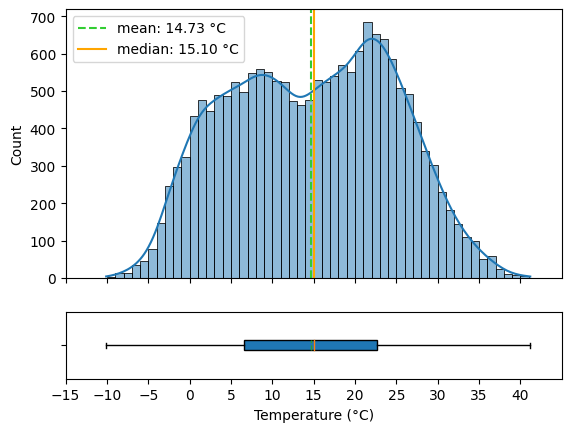

In [14]:
distboxplot(data=df_clean, column='temperature', bins=np.arange(-15,45,1),
            xticks=np.arange(-15,45,5), xlim=[-1,45], xlabel='Temperature (°C)', unit='°C')

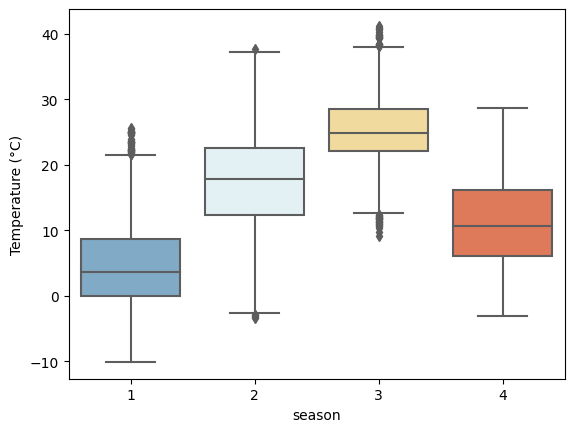

In [15]:
ax = sns.boxplot(data=df_clean, y='temperature', x='season', orient='v', palette='RdYlBu_r')
ax.set_ylabel('Temperature (°C)')
plt.show()

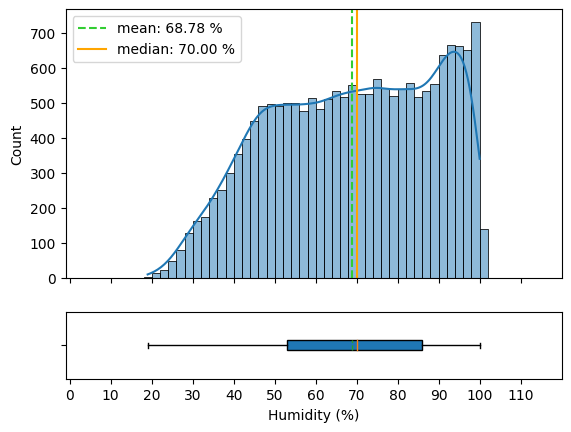

In [16]:
distboxplot(data=df_clean, column='humidity', bins=np.arange(0,120,2),
            xticks=np.arange(0,120,10), xlim=[-1,120], xlabel='Humidity (%)', unit='%')

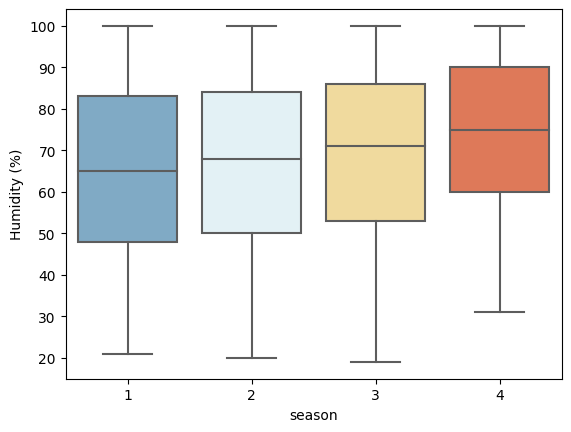

In [17]:
ax = sns.boxplot(data=df_clean, y='humidity', x='season', orient='v', palette='RdYlBu_r')
ax.set_ylabel('Humidity (%)')
plt.show()

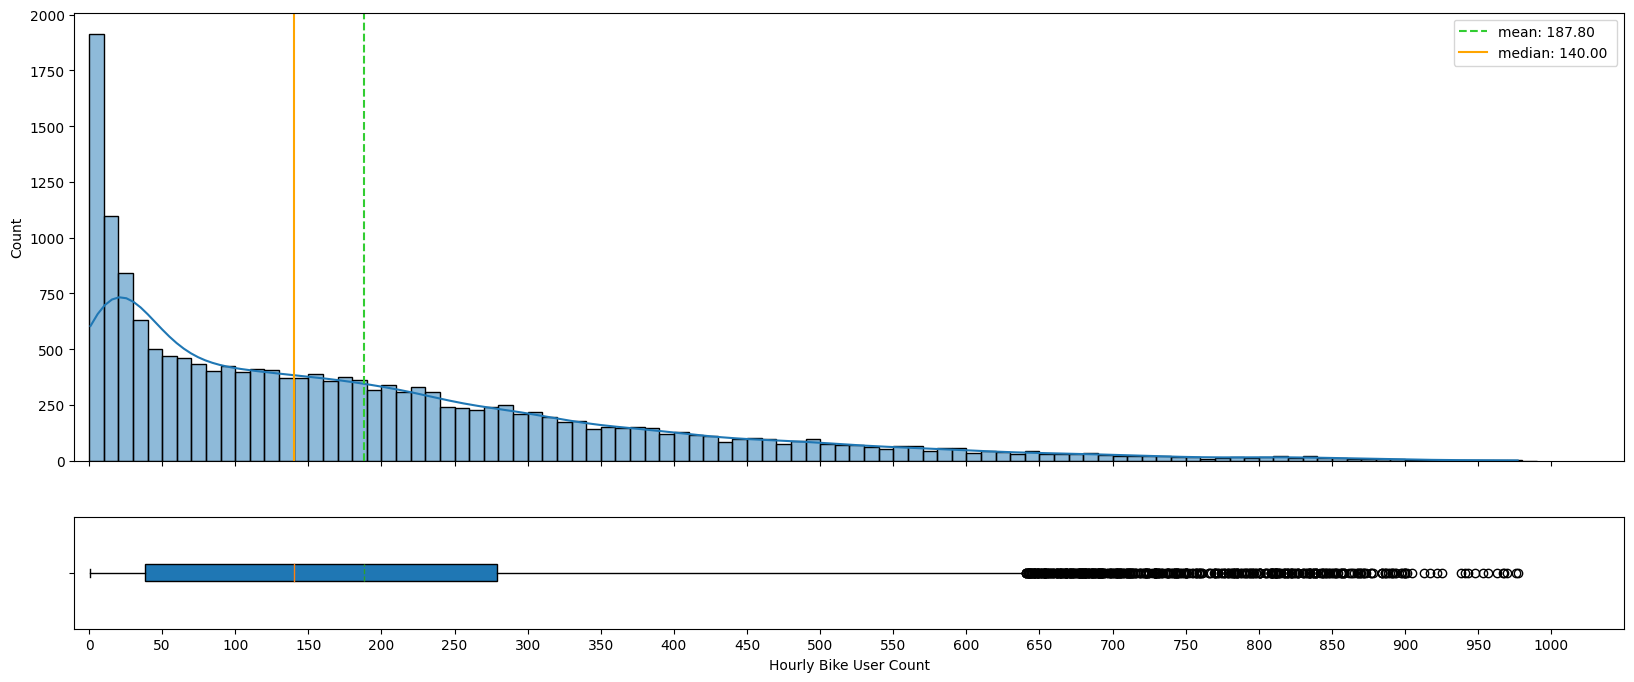

In [18]:
distboxplot(data=df_clean, column='count', bins=np.arange(0,1000,10),
            xticks=np.arange(0,1050,50), xlim=[-10,1050], xlabel='Hourly Bike User Count', unit='', figsize=(20,8))

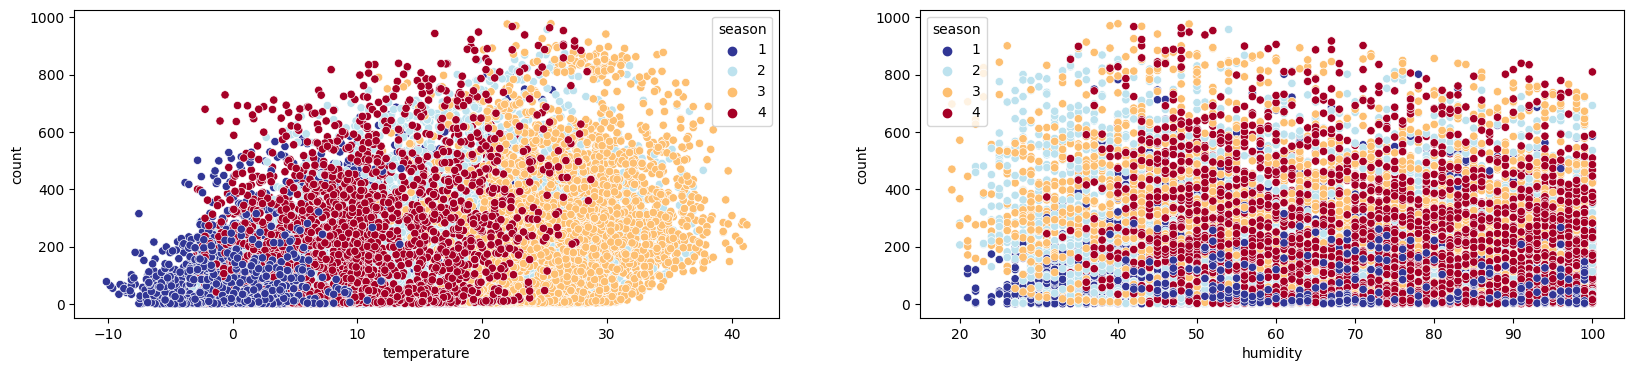

In [19]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,4))
numerical = ['temperature', 'humidity']
for i, col in enumerate(numerical):
    sns.scatterplot(data=df_clean, x=col, y='count', hue='season', palette='RdYlBu_r', ax=axes[i])

### **2.3 Numerical, Discrete Variable**

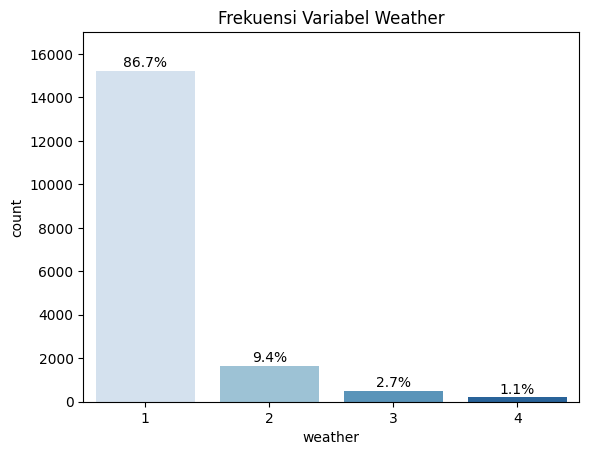

In [20]:
plt.title("Frekuensi Variabel Weather")
ax = sns.countplot(data=df_clean, x="weather", palette="Blues")
ax.set_ylim([0, 17000])

for p in ax.patches:
    percentage = f'{100 * p.get_height() / len(df_clean):.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')

plt.show()

In [21]:
# # df_clean['weather'] = np.where(df_clean['weather'].isin([3,4]), 3, df_clean['weather'])
# plt.title("Frekuensi Variabel Weather")
# ax = sns.countplot(data=df_clean, x="weather", palette="Blues")
# ax.set_ylim([0, 17000])

# for p in ax.patches:
#     percentage = f'{100 * p.get_height() / len(df_clean):.1f}%\n'
#     x = p.get_x() + p.get_width() / 2
#     y = p.get_height()
#     ax.annotate(percentage, (x, y), ha='center', va='center')

# plt.show()

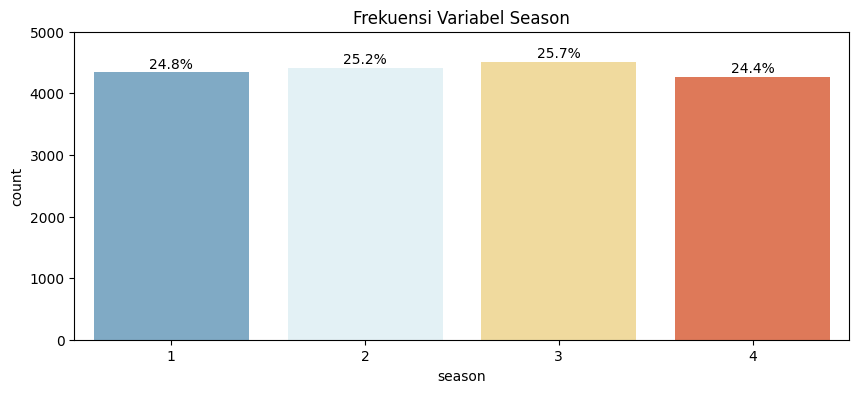

In [22]:
plt.subplots(figsize=(10, 4))
plt.title("Frekuensi Variabel Season")
ax = sns.countplot(data=df_clean, x="season", palette="RdYlBu_r")
ax.set_ylim([0, 5000])

for p in ax.patches:
    percentage = f'{100 * p.get_height() / len(df_clean):.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')

plt.show()

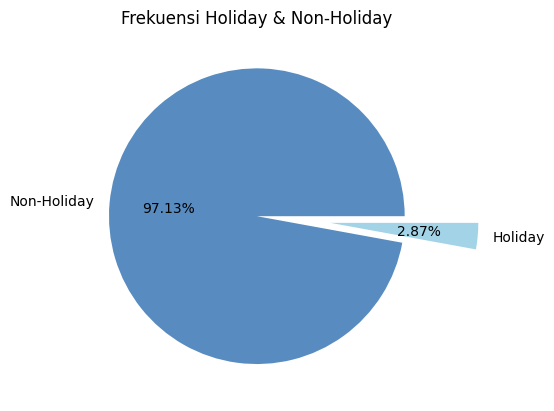

In [23]:
tmp_df = df_clean['holiday'].value_counts(normalize=True) * 100
explode = [0, 0.5]
plt.title("Frekuensi Holiday & Non-Holiday")
plt.pie(
    x=[tmp_df.loc[0], tmp_df.loc[1]], 
    labels=['Non-Holiday', 'Holiday'], 
    colors=sns.color_palette('RdYlBu_r'), 
    autopct='%.2f%%',
    explode=explode
)
plt.show()

## `3. Data Split`

In [24]:
skim_data(df_clean)

,column,type,n_unique,min,max,sample_unique
0,dteday,object,731,2011-01-01,2012-12-31,"[2011-01-01, 2011-01-02, 2011-01-03, 2011-01-0..."
1,month,int64,12,1,12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
2,dayofweek,int64,7,1,7,"[6, 7, 1, 2, 3, 4, 5]"
3,hour,int64,24,0,23,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,holiday,int64,2,0,1,"[0, 1]"
5,season,int64,4,1,4,"[1, 2, 3, 4]"
6,weather,int64,4,1,4,"[1, 2, 3, 4]"
7,temperature,float64,479,-10.1,41.2,"[4.3, 3.4, 2.7, 2.2, 1.8, 1.7, 1.6, 1.3, 1.9, ..."
8,humidity,int64,82,19,100,"[82, 86, 89, 91, 93, 94, 96, 98, 99, 95, 80, 8..."
9,count,int64,869,1,977,"[16, 40, 32, 13, 1, 2, 3, 8, 14, 36, 56, 84, 9..."


In [25]:
# df_clean.to_csv('../data/raw/clean_bike.csv', index=False)

In [26]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit

# test data is second half of 2012 (2012-07-01 to 2012-12-31)
df_train, df_test = train_test_split(df_clean, test_size=24*184, shuffle=False)
display(skim_data(df_train), skim_data(df_test))

,column,type,n_unique,min,max,sample_unique
0,dteday,object,547,2011-01-01,2012-06-30,"[2011-01-01, 2011-01-02, 2011-01-03, 2011-01-0..."
1,month,int64,12,1,12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
2,dayofweek,int64,7,1,7,"[6, 7, 1, 2, 3, 4, 5]"
3,hour,int64,24,0,23,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,holiday,int64,2,0,1,"[0, 1]"
5,season,int64,4,1,4,"[1, 2, 3, 4]"
6,weather,int64,4,1,4,"[1, 2, 3, 4]"
7,temperature,float64,473,-10.1,40.3,"[4.3, 3.4, 2.7, 2.2, 1.8, 1.7, 1.6, 1.3, 1.9, ..."
8,humidity,int64,82,19,100,"[82, 86, 89, 91, 93, 94, 96, 98, 99, 95, 80, 8..."
9,count,int64,752,1,957,"[16, 40, 32, 13, 1, 2, 3, 8, 14, 36, 56, 84, 9..."


,column,type,n_unique,min,max,sample_unique
0,dteday,object,184,2012-07-01,2012-12-31,"[2012-07-01, 2012-07-02, 2012-07-03, 2012-07-0..."
1,month,int64,6,7,12,"[7, 8, 9, 10, 11, 12]"
2,dayofweek,int64,7,1,7,"[7, 1, 2, 3, 4, 5, 6]"
3,hour,int64,24,0,23,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,holiday,int64,2,0,1,"[0, 1]"
5,season,int64,3,1,4,"[3, 4, 1]"
6,weather,int64,4,1,4,"[1, 2, 3, 4]"
7,temperature,float64,414,-3.1,41.2,"[26.2, 26.3, 26.1, 25.5, 25.2, 24.8, 24.4, 24...."
8,humidity,int64,79,21,100,"[85, 83, 86, 87, 88, 90, 91, 74, 79, 82, 66, 5..."
9,count,int64,817,1,977,"[149, 93, 90, 33, 4, 10, 27, 50, 142, 219, 366..."


In [27]:
# df_train.to_csv('../data/raw/train.csv', index=False)
# df_test.to_csv('../data/raw/test.csv', index=False)